# Sperm whales detection 

- Try bounding box (yolo v3)
- Try segmentation? 
- More data augmentation 
- Triplet loss
- Add a validation strategy

### Import libraries 

In [1]:
import os
import shutil
from random import sample, choice
import pandas as pd
import numpy as np
import pickle
from os.path import isfile

import matplotlib.pyplot as plt
from PIL import Image

import torchvision.transforms as transforms
from tqdm import tqdm_notebook
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch import optim
import torch.nn.functional as F
from numpy import asarray
import torchvision.datasets as dset
import random
import torchvision
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

### Load data 

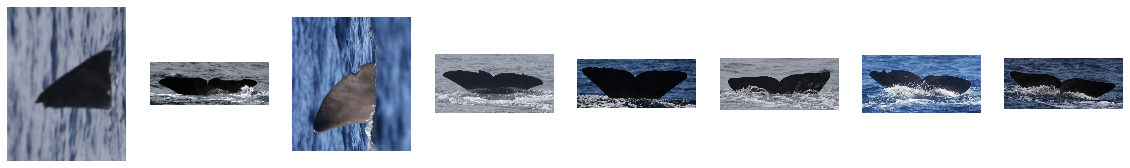

In [2]:
fig = plt.figure(figsize=(20, 20))
raw_datapath = os.path.join('data', 'raw', 'Whale Watch Azores 2016')
imgs = [os.path.join(raw_datapath, img) for img in os.listdir(raw_datapath) if '.jpg' in img]
for i in range(8):
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(Image.open(imgs[i]))
    ax.autoscale(False)
    ax.axis('off')
plt.show()

### Configuration class 

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class Config():
    training_dir = "data/train/"
    testing_dir = "data/test_val/"
    train_batch_size = 64
    train_number_epochs = 100

### SNN Data loader 

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        #or the model will only learn how to detect 2 different whales
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert('L')
        img1 = img1.convert('L')
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

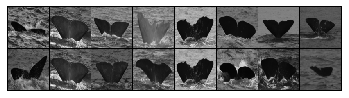

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=0,
                            batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### Model 

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

### Loss

In [13]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


### Training 

In [42]:
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=0,
                              batch_size=Config.train_batch_size)

In [43]:
net = SiameseNetwork()#.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [44]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.726185917854309

Epoch number 0
 Current loss 0.7899608612060547

Epoch number 0
 Current loss 0.6942555904388428

Epoch number 0
 Current loss 1.3771171569824219

Epoch number 0
 Current loss 0.6389395594596863

Epoch number 0
 Current loss 1.2808905839920044

Epoch number 0
 Current loss 1.0677003860473633

Epoch number 1
 Current loss 1.2255699634552002

Epoch number 1
 Current loss 1.0189121961593628

Epoch number 1
 Current loss 1.0014010667800903

Epoch number 1
 Current loss 1.9174305200576782

Epoch number 1
 Current loss 0.536750078201294

Epoch number 1
 Current loss 1.14719557762146

Epoch number 1
 Current loss 0.33710402250289917

Epoch number 2
 Current loss 1.0280709266662598

Epoch number 2
 Current loss 1.0733062028884888

Epoch number 2
 Current loss 0.6881730556488037

Epoch number 2
 Current loss 0.7788699865341187

Epoch number 2
 Current loss 0.9570631980895996

Epoch number 2
 Current loss 0.5948514938354492

Epoch number 2
 Current

Epoch number 23
 Current loss 0.22748544812202454

Epoch number 23
 Current loss 0.25873318314552307

Epoch number 23
 Current loss 0.2695598602294922

Epoch number 24
 Current loss 0.29807785153388977

Epoch number 24
 Current loss 0.39335423707962036

Epoch number 24
 Current loss 0.24673894047737122

Epoch number 24
 Current loss 0.2845084071159363

Epoch number 24
 Current loss 0.17301052808761597

Epoch number 24
 Current loss 0.23761533200740814

Epoch number 24
 Current loss 0.27075958251953125

Epoch number 25
 Current loss 0.2623828947544098

Epoch number 25
 Current loss 0.16676944494247437

Epoch number 25
 Current loss 0.252260684967041

Epoch number 25
 Current loss 0.2802339792251587

Epoch number 25
 Current loss 0.24875867366790771

Epoch number 25
 Current loss 5.032571315765381

Epoch number 25
 Current loss 0.14280909299850464

Epoch number 26
 Current loss 0.18141257762908936

Epoch number 26
 Current loss 0.29208359122276306

Epoch number 26
 Current loss 0.3789871

Epoch number 46
 Current loss 0.07530590146780014

Epoch number 46
 Current loss 0.15441440045833588

Epoch number 47
 Current loss 0.20952090620994568

Epoch number 47
 Current loss 0.13204073905944824

Epoch number 47
 Current loss 0.11848709732294083

Epoch number 47
 Current loss 0.11441262066364288

Epoch number 47
 Current loss 0.06618336588144302

Epoch number 47
 Current loss 0.059720300137996674

Epoch number 47
 Current loss 0.10305725783109665

Epoch number 48
 Current loss 0.09615567326545715

Epoch number 48
 Current loss 0.08685734868049622

Epoch number 48
 Current loss 0.06581133604049683

Epoch number 48
 Current loss 0.11414983123540878

Epoch number 48
 Current loss 0.06484193354845047

Epoch number 48
 Current loss 0.08171180635690689

Epoch number 48
 Current loss 0.13900330662727356

Epoch number 49
 Current loss 0.08993247896432877

Epoch number 49
 Current loss 0.06738331913948059

Epoch number 49
 Current loss 0.060906097292900085

Epoch number 49
 Current loss

Epoch number 69
 Current loss 0.03220082446932793

Epoch number 69
 Current loss 0.04151308536529541

Epoch number 70
 Current loss 0.099051833152771

Epoch number 70
 Current loss 0.05882606655359268

Epoch number 70
 Current loss 0.05181550607085228

Epoch number 70
 Current loss 0.05659998953342438

Epoch number 70
 Current loss 0.05252827703952789

Epoch number 70
 Current loss 0.035164184868335724

Epoch number 70
 Current loss 0.03216313570737839

Epoch number 71
 Current loss 0.03004269488155842

Epoch number 71
 Current loss 0.04960906505584717

Epoch number 71
 Current loss 0.06557836383581161

Epoch number 71
 Current loss 0.11991826444864273

Epoch number 71
 Current loss 0.0771135538816452

Epoch number 71
 Current loss 0.06549812853336334

Epoch number 71
 Current loss 0.12193238735198975

Epoch number 72
 Current loss 0.05398866906762123

Epoch number 72
 Current loss 0.08086729049682617

Epoch number 72
 Current loss 0.057912975549697876

Epoch number 72
 Current loss 0.

Epoch number 92
 Current loss 0.07018367946147919

Epoch number 92
 Current loss 0.10641036182641983

Epoch number 93
 Current loss 0.0680769607424736

Epoch number 93
 Current loss 0.08036614209413528

Epoch number 93
 Current loss 0.16302978992462158

Epoch number 93
 Current loss 0.13988418877124786

Epoch number 93
 Current loss 0.11923805624246597

Epoch number 93
 Current loss 0.1493270844221115

Epoch number 93
 Current loss 0.13694995641708374

Epoch number 94
 Current loss 0.17359469830989838

Epoch number 94
 Current loss 0.11615832149982452

Epoch number 94
 Current loss 0.09537315368652344

Epoch number 94
 Current loss 0.10512728989124298

Epoch number 94
 Current loss 0.08530956506729126

Epoch number 94
 Current loss 0.07832518965005875

Epoch number 94
 Current loss 0.09423572570085526

Epoch number 95
 Current loss 0.049798715859651566

Epoch number 95
 Current loss 0.09094704687595367

Epoch number 95
 Current loss 0.0677170604467392

Epoch number 95
 Current loss 0.0

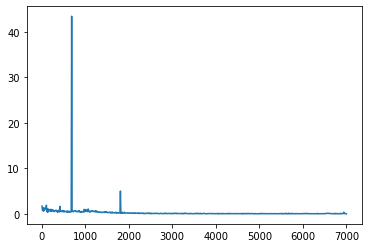

In [45]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0,img1,label#.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [46]:
torch.save(net.state_dict(), 'snn_v1.pt')

In [53]:
loss_per_epoch = [loss_history[i] for i in range(0, len(loss_history), 7)]

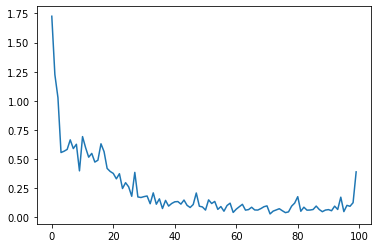

In [55]:
plt.plot(loss_per_epoch)

### Testing set 

In [14]:
net = SiameseNetwork()
net.load_state_dict(torch.load('snn_v1.pt'))
net.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [15]:
#Config.training_dir
def train_data_inf(folder):
    res = []
    folder_files = os.listdir(folder)
    for fld in folder_files:
        if fld[0]!=('.'):
            whale_class = os.listdir(os.path.join(folder, fld))
            for f_ in whale_class:
                res.append(os.path.join(folder, fld, f_))
    return res

In [16]:
train_data_img = train_data_inf(Config.training_dir)
print(len(train_data_img))

3962


In [17]:
imgs_test = [os.path.join('data/test_val/', img) for img in os.listdir('data/test_val/') if '.jpg' in img]
print(len(imgs_test))

808


In [21]:
def native_augmentation():
    augmentation = transforms.Compose([
        transforms.Resize((100,100)),
        transforms.ToTensor()])
    return augmentation

class Dataloader_test(Dataset):
    def __init__(self,imgs):
        self.data=imgs
        self.trans=native_augmentation()
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        img = img.convert('L')
        return self.trans(img)
    
    def __len__(self):
        return len(self.data)

test_dataset = Dataloader_test(imgs_test)
test_dataloader = DataLoader(test_dataset, 
                             shuffle = False,
                             batch_size=1,
                             num_workers=0)

train_dataset = Dataloader_test(train_data_img)
train_dataloader = DataLoader(train_dataset, 
                              shuffle = False,
                              batch_size=1,
                              num_workers=0)

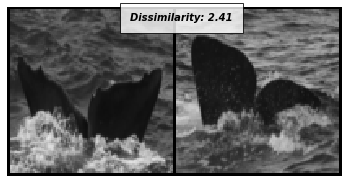

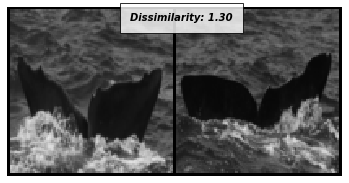

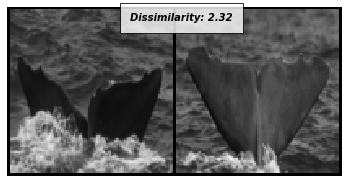

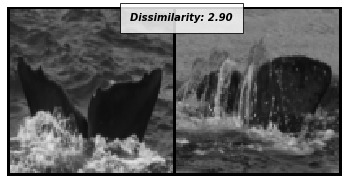

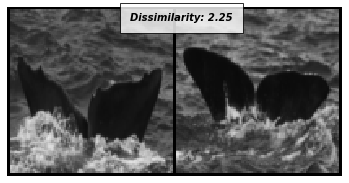

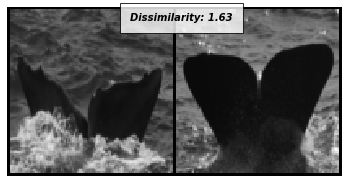

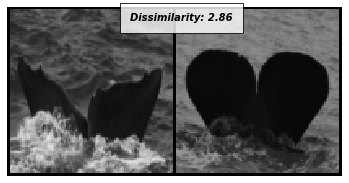

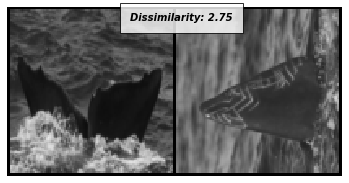

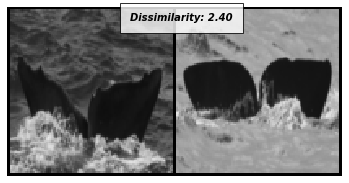

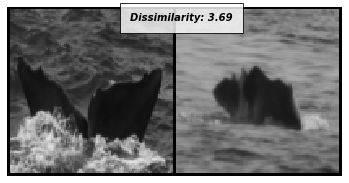

In [22]:
dataiter = iter(test_dataloader)
x0 = next(dataiter)

for i in range(10):
    x1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))